# Objectives
The objective of this notebook is as follows:
- Define a geographic search area (via latitude / longitude bounded area)
- Use the Foursquare **Place Search** API to return all venues of a particular type (e.g. bars) within the search area
- Use the Foursquare **Get Place Details** API to return rich information on each of the venues

The end result will be a csv file containing all venues found and their associated Foursquare data. The total cost of the API calls for a big city is ~\\$20 and thus the free tier Sandbox membership (\\$200 of free API calls per month) comfortably covers the costs.  

In [1]:
import json
import ast
import random
import requests
from IPython.display import JSON
from ratelimiter import RateLimiter
from statistics import median, mean
from math import sin, cos, asin, sqrt, degrees, radians
import plotly.express as px
from geopy import distance
from scipy.optimize import newton
import numpy as np
import pandas as pd
import time
from datetime import datetime
from joblib import Parallel, delayed

## Approach
Below we provide a high level overview of how the venue search works. 
### Define Search Area
We define the search area using maximum and minimum latitude and longitude values. The intersection of these lines of latitude and longitude define a square area. Below we define these values for London and then visualise the area on a map. 

In [6]:
# Define search area via min and max latitude and longitude
min_lat = 51.438499 
max_lat = 51.546890
min_long = -0.240612
max_long = 0.026043

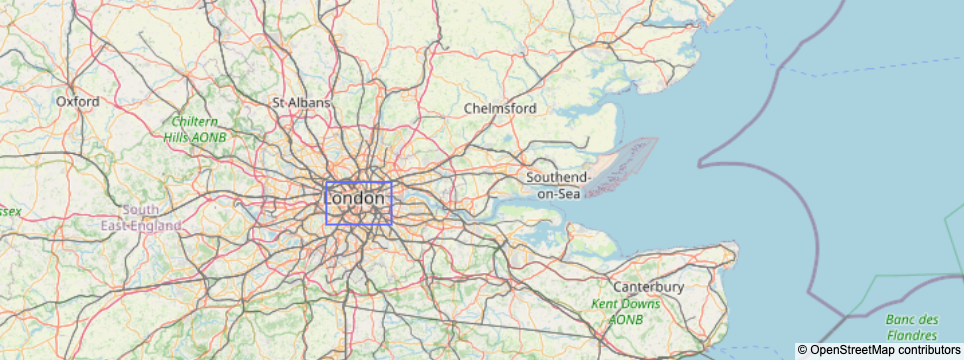

In [7]:
# Define the 4 corners of the search area using the max / min lat and 
# long values
search_boundaries = [[max_lat, min_long],[max_lat, max_long], 
                     [min_lat, max_long], [min_lat,min_long], 
                     [max_lat, min_long]]
# Convert to Dataframe
df_boundaries = pd.DataFrame(search_boundaries, 
                             columns = ['latitude', 'longitude'])

# Plot as square area on a map
fig = px.line_mapbox(df_boundaries, lat="latitude", lon="longitude", zoom = 9)
fig.update_layout(mapbox_style="open-street-map", mapbox_zoom = 9, 
                  margin = {"r":0,"t":0,"l":0,"b":0})
fig.update_layout(
    autosize=False,
    width=800,
    height=300,)
fig.show()

### Find Venues Within Search Area
We will use the Foursquare [Place Search](https://developer.foursquare.com/reference/place-search) API to extract all venues from the search area. The Place Search API can take a location (defined as a latitude and longitude coordinate) and a radius and will return up to 50 venues found within that radius. 

Since it only returns 50 results, we will have to keep searching different locations until the whole search area has been covered. The search does not return the closest 50 results to the location. It returns a range of venues from across the whole search radius. As such, the only way to be sure you have found every single venue within a location, you must reduce the search radius until less than 50 results are showing. At this point, the API will only return the venues closest to the search location and we can be sure nothing is missing.

To perform the exhaustive search of the area, we first split the area into a grid of latitude / longitude points as shown below: 

![alt text](images/grid.png)

We will then randomly choose a point on the grid and perform an API search using an initial search radius. This search will cover a number of points in the grid depending on the size of the radius. An example search area is shown in red below: 

![alt text](images/initial_search.png)

We then check whether the search returned less than 50 results. If it didn't, we halve the search radius and search again, as shown below: 

![alt text](images/second_search.png)

We repeat this until the search returns less than 50 results. We then store the details of the venues from the search results and **remove** all points on the grid that were covered by the search i.e. within the final radius. This is shown below: 

![alt text](images/removed.png)

We are now ready to choose another location on the grid randomly and perform the search again. We do this until all points have been removed from the grid. At this point, the whole search area has been searched and we should have found all venues within the area. 

### Initial Search Radius
The reason we start off with a large search radius and keep reducing it, is that the density of venues varies significantly in different regions of the search area. There are large areas with few venues and small areas with many venues. Thus, the search is fastest if we can remove large areas of points on the grid where there is a low density of venues in a single search. As a result, we will quickly remove a large number of low density points from the grid. This means the points remaining in the grid are more likely to be high density points requiring a small search radius. This in turn means that as the venue search progresses, the initial search radius will become more and more likely to be too large and thus be a wasted API call. 

To optimise the process, we count the fraction of searches every 20 seconds that required a smaller radius than the initial search radius we are using. When this value goes over 60% (i.e. 60% of points need a smaller radius), we reduce the initial search radius used by 20%. This ensures we always have relatively large areas being removed in a single search and are not performing lots of small radius API calls. 

### Grid Separation
How small do we need to make the grid separations i.e. the distance between neighboring points in the grid (horizontal and vertical spacing only, not diagonal)? 

The grid separations need to be at least as small as the smallest search radius required. Otherwise we could end up with venues between 2 points on the grid that are not covered by the search radius from either point, and thus we wouldn't capture them. We chose to make the grid separations half the smallest radius required. 

We built finding the correct grid separation into the venue search process in the above section. You start off with an initial guessed minimum search radius required. From this, we build a grid using half this value as the grid separation. The venue search then continues until a search requires a radius smaller than our guessed smallest search radius. At this point, the whole venue search is restarted, the grid is recreated using the new smallest search required. This repeats until a smaller search radius is not found, and therefore the venue search manages to search the whole area successfully. 

## Define Place Search API Call
Below we define a function that takes a longitude / latitude coordinate and a radius and returns the response from the Foursquare [Place Search](https://developer.foursquare.com/reference/place-search) API. The response will contain up to 50 venues found within the radius.  

The foursquare API has a rate limit of 50 calls per second. We used the ratelimiter package to apply this rate limit to the function. 

The **key** is the private credential required to use the API (it links the API call to a users account). We stored the key in a key.txt file to keep it hidden. 

The following API Paramaters were used to define the search: 
- **ll** - comma seperated latitude and longitude value e.g. '5123,0.0324'
- **radius** - the radius (in meters) around the latitude / longitude value that will be included in the search.
- **categories** - commas separated list of category codes. The search will only return businesses within those categories. The categories can be found [here](https://developer.foursquare.com/docs/categories). We primarily searched for bars alongside some other categories. You can leave this blank to return all businesses within the search area. 
- **sort** - defines how to sort results. We sorted by distance i.e. closest to the latitude / longitude value first. 
- **limit** - maximum number of results returned. 50 is the max number Foursquare allows. 

In [3]:
# Import the foursquare key from text file (to keep key hidden on github)
with open('key.txt') as f:
    key = f.read()
# Base url string of the Place Search API call
search_url = "https://api.foursquare.com/v3/places/search"

# RateLimiter decorator, ensures the api_call function is called less 
# than 50 times per second, the Foursquare rate limit
@RateLimiter(max_calls=49, period=1)
def api_call(long_lat, radius, key):
    """Perform a foursquare places api search and return results.  
    
    The places api search requires a location (latitude and longitude) 
    and radius to determine the search area. We also use several category 
    codes to identify the type of businesses we want to return, in this 
    case bars and music venues, resticting our results to showing only 
    bars and music venues. 
    
    Note that the function uses the @Ratelimiter decorator to restrict the 
    calling of this function to 49 calls per second to comply with the 
    foursquare api rate limits.  
    
    Returns - response from foursquare api (top 50 venues (bars and music
    venues) closest to the latitude / longitude values provided)"""
    
    # Defines paramaters to add to the search_url. These define the Search.  
    params = dict(ll = long_lat,
                  radius = radius, 
                  # The below commented out categories were used in testing. 
                  # They return event spaces only, and there are only around 
                  # 330 of them in the geographic area, so it makes a useful
                  # fast test search. 
                  #categories='11131,11039',
                  categories='10039,10040,10041,10045,10049,11039,13003',
                  sort='DISTANCE',
                  limit='50'
                 )
    # Defines headers required in Place Search API call
    headers = {
        "Accept": "application/json",
        "Authorization": key
    }

    return requests.request("GET", search_url, headers=headers, params=params)

Below we perform a test Place Search API call to check it works as expected. It should return a JSON file containing a list of results. 

In [4]:
# Perform Place Search API call
response = api_call('51.513882,-0.119478', '1000', key)
# extract results from response as json file
results = json.loads(response.text)
# Visualise results
JSON(results)

<IPython.core.display.JSON object>

The below calculates the cost for a certain number of Foursquare API calls.

In [10]:
total_requests = 8000
cost_per_request = 0.50
total_price_in_dollars = total_requests * cost_per_request / 100
print(f"Total price for {total_requests} requests is ${total_price_in_dollars}")

Total price for 8000 requests is $40.0


## Create Latitude Longitude Grid
### Calculate Latitude Longitude Grid Tick Size

We will create a grid of latitude and longitude points which spans the geographic area being searched. Each point on the grid will be separated from its nearest (adjacent) neighbours horizontally by a longitude increment (for neighbours to the East or West of the point) or vertically by a latitude increment (for neighbours North or South of the point). 

We want the distance between adjacent points on the grid (the minimum grid separation) to be half of a minimum search radius that we define. Thus, we want to find the latitude and longitude increments required to get this distance. We can then use these latitude and longitude increments to create our grid. 

![alt text](images/Grid_Sep.png)

The below functions take a minimum search radius and return the latitude and longitude tick sizes (increments). These tick sizes are the latitude and longitude increments required to create a grid with a minimum separation of half the minimum search radius provided.

Converting latitude and longitude increments into distance is a bit tricky. Our solution was to use the Newton Optimiser from Scipy. This optimiser finds the zero point of a function. We then created a function that calculates the distance between 2 points with the same longitude but different latitudes. The function then subtracts this distance from a provided radius and returns this value. The Newton optimiser will then vary the latitude differences between the points until the distance between the points equals the radius, at this point the function returns zero. This latitude difference then gives us our latitude tick size. We created a similar function that varies the longitude instead to find the longitude tick size. 

In [11]:
# Calculate central lat long position of the geographic area. 
centre_lat = (max_lat + min_lat) / 2
centre_long = (max_long + min_long) / 2

def find_tick_sizes(radius):
    """returns latitude and longitude tick size required for grid 
    separation of 1/2 the provided radius. 
    """
    # Applies Newton optimiser on lat_min_tick_size function - varies
    # first argument of function to make the function 0. It is varying
    # the latitude of the central lat long point and finding what new 
    # latitude would result in a distance equal to the provided radius 
    # between the central lat long point and this new point. 
    lat_new = newton(lat_min_tick_size, centre_lat, args = (radius,))
    # Applies Newton optimiser on long_min_tick_size function - same as 
    # above but this time the longitude is varied. 
    long_new = newton(long_min_tick_size, centre_long, args = (radius,))
    
    # divide by 2 to get smaller resolution grid separation
    lat_tick_size = abs(centre_lat - lat_new) / 2
    long_tick_size = abs(centre_long - long_new) / 2

    return lat_tick_size, long_tick_size

def lat_min_tick_size(lat_new, radius):
    """Calculate distance between central point and the central point 
    with a shifted latitude then subtract radius from this."""
    return distance.distance((centre_lat, centre_long), 
                             (lat_new, centre_long)).m - radius

def long_min_tick_size(long_new, radius):
    """Calculate distance between central point and the central point 
    with a shifted longitude then subtract radius from this."""
    return distance.distance((centre_lat, centre_long), 
                             (centre_lat, long_new)).m - radius

### Create Latitude Longitude Grid

The below function takes a latitude and longitude tick sizes and creates a latitude longitude grid spanning the geographic area (defined by max_lat, min_lat, max_long, min_long). The points on the grid will be separated vertically by the latitude tick size and horizontally by the longitude tick size.

The grid is stored as a one dimensional list and each latitude longitude coordinate is saved as a string e.g. '56.01,0.0034'. A single list was chosen to keep things simple and so that any point on the grid can be  randomly selected by generating a random list index.

In [12]:
def create_lat_long_grid(lat_tick_size, long_tick_size):
    """Create latitude longitude grid with latitude and longitude 
    separations defined by the provided tick sizes.
    
    The grid spans the geographic area (defined by max_lat, min_lat, 
    max_long, min_long)
    
    Returns - list of latitude longitude points in string format 
    e.g. '56.01,0.0034' """
    
    # Calculate the full range of latitudes within the grid (every latitude 
    # from min_lat to max_lat, incremented by lat_tick_size)
    lat_range = np.arange(min_lat, max_lat + lat_tick_size, lat_tick_size)
    # Calculate the full range of longitudes within the grid (every longitude
    # from min_long to max_long, incremented by long_tick_size)
    long_range = np.arange(min_long, max_long + long_tick_size, long_tick_size)
    
    # Return full grid. This effectively starts with the minimum longitude and 
    # loops through all the latitudes and stores the combination of minimum 
    # longitude and latitude as points in the list. It then increments the 
    # longitude and loops through the latitudes again. This repeats until 
    # all combinations of latitude and longitude are stored in the list.  
    return [str(lat) + ',' + str(long) for long in long_range for lat in lat_range]

## Update Grid
To recap, we search the geographic area by randomly selecting a point on the latitude longitude grid and then repeatedly call the Place Search API with a decreasing radius until the search returns less than 50 venues. A this point, we extract the venues returned from the API response. Then we update the latitude longitude grid by removing the points on the grid that are within the search radius. This overall process is repeated until no points remain on the grid. 

Below, we detail some of the functions and specifics used in this process. 

### Extract Venues From Foursquare Response
The Place Search API returns a response that contains a list of up to 50 venues. We want to extract the venue data (name, location etc.) of each venue. To do this we do the following:
- Extract text from API response and convert to JSON file 
- Filter the JSON on 'results' - this gives us a list of the up to 50 venues, where each element in the list is a dictionary containing the data for one venue. 
- Pass the list of venue data to the *extract_venues* function, this extracts the data from each element of the list and returns the data as a list of lists. 

In [13]:
def extract_venues(venue_list):
    """Extracts desired data from venue_list and returns as list of lists
    
    Paramaters:
    venue_list - list of dictionaries, each dictionary contains the data
    for a venue. 
    
    Returns - List of lists containing the desired venue data for all venues 
    """
    venues = []
    # Loop through venue_list, each element is a nested dictionary containing 
    # data for a venue
    for venue in venues_list:
        # Foursquare ID, unique reference for the venue
        fsq_id = venue['fsq_id']
        latitude = venue['geocodes']['main']['latitude']
        longitude = venue['geocodes']['main']['longitude']
        venue_name = venue['name']
        # address and postcode data not always present, so use error handling
        try: 
            venue_address = venue['location']['address']
        except KeyError:
            venue_address = ''
        try:
            venue_postcode = venue['location']['postcode']
        except KeyError:
            venue_postcode = ''
            
        venues.append([fsq_id, venue_name, latitude, longitude, 
                       venue_address, venue_postcode])
    return venues

### Identifying Points within Radius
Our grid typically becomes very large. For our geographic area with a minimum search radius of ~30m we get a grid with ~1,000,000 points on it. We need to identify all points on the grid within a certain radius from a search point so that we can remove them. The brute force way to identify them is to loop through the entire grid and calculate the distance between every point and our search point. This is a very slow process and can increase the overall search time by several hours. 

To speed this up, we borrowed code from [this](https://stackoverflow.com/questions/3182260/python-geocode-filtering-by-distance) stack overflow post (shown below). The *bounding_box* function takes a latitude and longitude coordinate and a radius and returns values **dlat** and **dlong**. These values define a smaller subset of the entire grid that includes all coordinates with latitude within +- dlat of the latitude provided to *bounding_box* **and** longitude within +- dlong of the longitude provided to *bounding_box*. Only values within this subset can possibly be within the radius from the provided latitude and longitude point. We then calculate the distance between every point in the small subset and the provided latitude and longitude to identify which points are within the radius. 

We use this method to quickly identify which points on the grid are within a radius of the search point. This massively sped up the total search time to ~15 minutes rather than hours. 

In [14]:
Earth_radius_km = 6371.0
RADIUS = Earth_radius_km

def haversine(angle_radians):
    return sin(angle_radians / 2.0) ** 2

def inverse_haversine(h):
    return 2 * asin(sqrt(h)) # radians

def distance_between_points(lat1, lon1, lat2, lon2):
    # all args are in degrees
    # WARNING: loss of absolute precision when points are near-antipodal
    lat1 = radians(lat1)
    lat2 = radians(lat2)
    dlat = lat2 - lat1
    dlon = radians(lon2 - lon1)
    h = haversine(dlat) + cos(lat1) * cos(lat2) * haversine(dlon)
    return RADIUS * inverse_haversine(h)

def bounding_box(lat, lon, distance):
    # Input and output lats/longs are in degrees.
    # Distance arg must be in same units as RADIUS.
    # Returns (dlat, dlon) such that
    # no points outside lat +/- dlat or outside lon +/- dlon
    # are <= "distance" from the (lat, lon) point.
    # Derived from: http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates
    # WARNING: problems if North/South Pole is in circle of interest
    # WARNING: problems if longitude meridian +/-180 degrees intersects circle of interest
    # See quoted article for how to detect and overcome the above problems.
    # Note: the result is independent of the longitude of the central point, so the
    # "lon" arg is not used.
    dlat = distance / RADIUS
    dlon = asin(sin(dlat) / cos(radians(lat)))
    return degrees(dlat), degrees(dlon)

### Updating Grid
The below functions use the *bounding_box* function detailed above to take a search coordinate and radius and to remove all points on the grid within that radius of the search coordinate. 

In [15]:
def update_grid(lat_long_searched, radius, lat_long_grid):
    """Remove coords in lat_long_grid within radius from lat_long_searched coord"""
    
    # Split lat_long_searched into separate latitutde and longitude value
    lat_searched, long_searched = split_lat_long(lat_long_searched)
    # Extract bounding box dlat and dlong values that define minumum 
    # set of latitude and longitude values that can be within radius
    dlat, dlong = bounding_box(lat_searched, long_searched, radius/1000)
    # Loop through latitude longitude grid and keep point if 
    # check_in_radius returns True
    return [lat_long for lat_long in lat_long_grid 
            if check_in_radius(radius, lat_long_searched, lat_long, 
                               lat_searched, long_searched, dlat, dlong)]

def split_lat_long(lat_long):
    """Split comma seperate latitude and longitude into seperate latitude 
    and longitude values and return as floats.
    
    e.g. from '51.23,0.034' to 51.23, 0.0034"""
    # Split lat_long into list using separator ',' 
    lat_long_split = lat_long.split(',')
    return float(lat_long_split[0]), float(lat_long_split[1])

def check_in_radius(radius, lat_long_searched, lat_long, 
                    lat_searched, long_searched, dlat, dlong):
    """Check whether lat_long provided is within radius of lat_long_searched
    
    Returns - True if lat_long NOT within radius, returns False if lat_long
    within radius """
    
    lat, long = split_lat_long(lat_long)
    
    # Checks if lat and long are within the region lat_searched +- dlat 
    # AND long_searched within +- dlong. Only coordinates within this 
    # region can be within radius of lat_long_searched
    if (lat_searched - dlat < lat < lat_searched + dlat 
        and long_searched - dlong < long < long_searched + dlong):
        # Calculate distance in m between lat_long_searched and lat_long. 
        # Uses ast.literal_eval to convert the text format latitude and 
        # longitude values to comma separated integers as required by 
        # the distance.distance function.    
        distance_from_search = distance.distance(
            ast.literal_eval(lat_long_searched), 
            ast.literal_eval(lat_long)
        ).m
        # if distance is larger than radius + 1, returns True, otherwise 
        # returns false if distance less than radius i.e. point is within 
        # radius of lat_long_searched. 
        
        # NOTE - changed >= to > , perhaps change back or consider consequences...
        return distance_from_search > radius
    return True

## Performing the Search
The below code performs an exhaustive search of the geographic area as follows:
1. Define initial search radius and...

There are key variables that require tuning for your specific search. We detail them below along with tips for tuning: 
- initial_search_radius
- min_grid_radius
- time_between_updates
- categories to search for

Consider placing these in a table with heades |name|description|tuning Advice| 

Example tuned variables: 
- event spaces -> 1500, 750
- Bars etc. -> 1000, 30 

In [16]:
initial_search_radius = 1000
min_grid_radius = 30

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []

total_calls = 0
number_needed_retries = 0 
number_lat_long_in_last_20 = 0
radius_too_big = False 
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    
    search_radius_not_found = True
    search_radius = initial_search_radius
    
    while search_radius_not_found:
        #print('calling api')
        total_calls += 1
        response = api_call(lat_long, search_radius, key)
        # If response status code isnt 200, there was an API error. Print 
        # the API error, wait 5 seconds and try API call again. Loop until 
        # status 200 code returned by API. 
        while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            response = api_call(lat_long, search_radius, key)
        
        results = json.loads(response.text)
        venues_list = results['results']
        
        if len(venues_list) > 49:
            search_radius = int(search_radius / 2)
            radius_too_big = True
            #print('radius too large') 
        else: 
            search_radius_not_found = False
    
    if search_radius < min_grid_radius:        
        print(f"\nSearch Radius smaller than min_grid_radius:\nlat_long = {lat_long}\nsearch radius = {search_radius}")
        print(f"\nUpdating min_grid_radius to {search_radius} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = search_radius
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
 
        radius_too_big = False
        number_lat_long_in_last_20 = 0 
        number_needed_retries = 0
        time_last_update = time.time()
        continue
    
    number_lat_long_in_last_20 += 1
    number_needed_retries += radius_too_big
    radius_too_big = False
    
    #print('data about to be scraped')
    data.extend(extract_venues(venues_list))
           
    lat_long_grid = update_grid(lat_long, search_radius, lat_long_grid)
    #print('done one grid mark --> ', len(lat_long_grid))
    if time.time() - time_last_update > 20:
        print(f"\nlat_long_grid points remaining -> {len(lat_long_grid)}")
        print(f"Number of lat / long searches completed in last 20 seconds --> {number_lat_long_in_last_20}")
        fraction_of_retries = number_needed_retries / number_lat_long_in_last_20
        if fraction_of_retries > 0.6 and number_lat_long_in_last_20 > 6:
            print(f"{number_needed_retries} out of {number_lat_long_in_last_20} " 
                  + f"searches had too large radius --> {fraction_of_retries:.1%}")
            initial_search_radius = int(initial_search_radius * 0.8)
            print(f"Reducing Initial Search Radius to {initial_search_radius}")
        
        time_last_update = time.time()
        number_lat_long_in_last_20 = 0 
        number_needed_retries = 0 
    
print(f"\nTotal Calls -> {total_calls}")

lat_long_grid size = 994980

lat_long_grid points remaining -> 969120
Number of lat / long searches completed in last 20 seconds --> 8
7 out of 8 searches had too large radius --> 87.5%
Reducing Initial Search Radius to 800

lat_long_grid points remaining -> 918235
Number of lat / long searches completed in last 20 seconds --> 9

lat_long_grid points remaining -> 854065
Number of lat / long searches completed in last 20 seconds --> 9

lat_long_grid points remaining -> 804778
Number of lat / long searches completed in last 20 seconds --> 9

lat_long_grid points remaining -> 759043
Number of lat / long searches completed in last 20 seconds --> 10

lat_long_grid points remaining -> 721073
Number of lat / long searches completed in last 20 seconds --> 10

lat_long_grid points remaining -> 671857
Number of lat / long searches completed in last 20 seconds --> 10

lat_long_grid points remaining -> 637148
Number of lat / long searches completed in last 20 seconds --> 11
7 out of 11 searches ha

## Notes 
- Number of calls per 20 second interval increases with time because the grid gets smaller, so faster to iterate over it to update it, more API calls possible
- Number of searches that require smaller radius increases with time, since low denisty areas tend to be removed (large numbers of low density points are removed, leaving mainly the high density regions and thus more smaller radius's needed

Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.49814499999999,-0.16857000000000005
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.48323349999999,-0.1205420000000001
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.51305649999998,-0.048500000000000154
radius = 3271
Error - 100 or more venues in search, cannot extract all venues in search area.
lat_long = 51.52796799999998,-0.048500000000000154
radius = 3271

In [107]:
venues = pd.DataFrame(data, columns = ['fsq_id', 'venue_name', 'latitude', 'longitude', 
                       'address', 'postcode'])
#venues.head()
venues = venues.drop_duplicates(subset=['fsq_id'])
venues.shape[0]

8814

In [108]:
venues[(min_lat <= venues.latitude) & (venues.latitude <= max_lat) 
   & (venues.longitude > min_long) & (venues.longitude < max_long)].shape[0]

8544

In [109]:
todays_date = datetime.today().strftime('%d-%b-%y')
venues.to_csv('foursquare_venues' + todays_date + '.csv', index = False)

In [ ]:
venues2 = pd.read_csv('foursquare_event_spaces.csv')
venues2.head()

In [ ]:
venues2[(min_lat <= venues2.latitude) & (venues2.latitude <= max_lat) 
   & (venues2.longitude > min_long) & (venues2.longitude < max_long)].shape[0]

In [ ]:
def blurgl error please
 a/0 
    
    dental mensd

In [ ]:
print(f"Error - 100 or more venues in search, cannot"
                     + f"blurg")

In [110]:
venues.head()

,fsq_id,venue_name,latitude,longitude,address,postcode
0,4c6ad2ba897b1b8dc8ccb217,Pegasus Bar & Restaurant,51.512793,-0.109119,Inner Temple,
1,4b3a6128f964a520fb6525e3,The Devereux,51.512775,-0.112463,20 Devereaux Ct,WC2R 3JJ
2,494faec273f140c5ec6e822d,Devereux Public House,51.512884,-0.112571,20 Devereux Ct,
3,d438f2ce44cb4972c5fa4a53,The Devereux - Taylor Walker,51.512884,-0.112571,20 Devereux Ct,WC2R 3JJ
4,4b634d25f964a520b0702ae3,Edgar Wallace,51.512585,-0.112819,40 Essex St,WC2R 3JE


## Get Venue Details

define API call 

[Get Place Details API](https://developer.foursquare.com/reference/place-details)

See [here](https://developer.foursquare.com/reference/response-fields#core-data-fields) for detailed information on the data that can be requested. 

In [23]:
venue_details_url = "https://api.foursquare.com/v3/places/"

#location,categories,chains,related_places,description,tel,fax,email,website,social_media,verified,hours_popular,stats,popularity,price,date_closed,tastes

# RateLimiter decorator, ensures the api_call function is called less 
# than 50 times per second, the Foursquare rate limit
@RateLimiter(max_calls=49, period=1)
def get_venue_details(fsq_id, key):
    """Get venue details using foursquare Get Place Details API
    
    Note that the fsq_id is appended to the API url, it is not a 
    paramater of the html request 
    
    Arguments:
    fsq_id - Foursquare ID for venue you are requesting details for
    key - authorisation key (links request to account paying for request) 
    
    Returns: 
    Html response from Foursquare that contains extended data on the venue
    """
    # Fields paramater defines what data foursquare will return
    fields = ['location', 'categories', 'chains', 'related_places',
              'tel', 'fax', 'email', 'website', 'verified', 
              'hours_popular', 'rating', 'stats', 'popularity', 
              'price', 'date_closed', 'tastes']
    # Convert fields to comma separated list
    fields = ','.join(fields)
    params = dict(fields = fields)
    headers = {
        "Accept": "application/json",
        "Authorization": key
    }
    # fsq_id is appended to end of API request url
    return requests.request("GET", venue_details_url + fsq_id, 
                            headers = headers, params = params)

In [55]:
# Perform Get Place Details API call
response = get_venue_details(venue_details_df.fsq_id[13], key)
# extract venue_details from response as json file
venue_details = json.loads(response.text)
# Visualise venue_details
JSON(venue_details)

<IPython.core.display.JSON object>

Data|Description
:---:|:---
email|contact email address of venue
tel|contact telephone number of venue
website|website of venue
verified|A boolean that indicates whether or not the FSQ Place has been claimed.
rating|A numerical rating (from 0.0 to 10.0) of the FSQ Place, based on user votes, likes/dislikes, tips sentiment, and visit data. Not all FSQ Places will have a rating.
popularity|Measure of the FSQ Place's popularity, by foot traffic. This score is on a 0 to 1 scale and uses a 6-month span of POI visits for a given geographic area.
price|A numerical value (from 1 to 4) that best describes the pricing tier of the FSQ Place, based on known prices for menu items and other offerings. Values include: 1 = Cheap, 2 = Moderate, 3 = Expensive, and 4 = Very Expensive
date_closed|The recorded date when the FSQ Place was marked as permanently closed in Foursquare's databases. This does not necessarily indicate the POI was actually closed on this date.
categories|An array, possibly empty, of categories that describe the FSQ Place. Stored as a list of strings. 
total_ratings|Total number of ratings for venue 
parent|If the venue is owned by a parent venue, the parent venue's name will be listed 
parent_fsq_id|If the venue is owned by a parent venue, the parent venue's foursquare ID will be listed 
neighborhood|Description of the neighborhood the venue is located in e.g. 'Clapham'. When initially extracted it is stored as a one item list.

In [7]:
def extract_simple_data(field, venue_details, fields):
    """Extracts data from venue_details json using the associated field
    
    Args:
        field (str): The field you wish to extract the value of e.g. 'email'.
        venue_details (json): The json file containing the data.
        fields (list): All fields contained by the json file. 

    Returns:
        bool/str/float/dict/np.nan: Returns the data stored in venue_details json 
            under the provided field. If the provided field does not exist in 
            the venue_details json, returns np.nan. 
    """
    if field in fields:
        return venue_details[field]
    else:
        return np.nan

def extract_venue_details(venue_details):
    """Extract data from venue_details json as a list
    
    Args:
        venue_details (json): The json file containing the venue details data.
        
    Returns:
        list: The data for the venue, e.g. 'email', 'price' etc. in a single 
            list. All data that couldnt be found is nan."""
    fields = venue_details.keys() 
    # Extract simple data from venue_details json
    email = extract_simple_data('email', venue_details, fields)
    tel = extract_simple_data('tel', venue_details, fields)
    website = extract_simple_data('website', venue_details, fields)
    verified = extract_simple_data('verified', venue_details, fields)
    rating = extract_simple_data('rating', venue_details, fields)
    popularity = extract_simple_data('popularity', venue_details, fields)
    price = extract_simple_data('price', venue_details, fields)
    date_closed = extract_simple_data('date_closed', venue_details, fields)

    # total_ratings is stored under 'stats' within the venue_details json. Below 
    # we extract the 'stats' dict from venue_details json and then extract 
    # total_ratings from that.  
    stats = extract_simple_data('stats', venue_details, fields)
    # Check stats wasn't nan
    if stats == stats:
        total_ratings = stats['total_ratings']
    else: 
        total_ratings = np.nan

    # Extract categories as a list of possible categories. If categories not
    # in json, return nan. 
    if 'categories' in fields:
        # Categories stored as a list in the venue_details json
        categories_list = venue_details['categories']
        categories = []
        # Loop through categories_list and extract the string name of each
        # category in the list. 
        for category in categories_list:
            categories.append(category['name'])        
    else:
        categories = np.nan

    # Extract parent from 'related_places' field. 'related_places' always
    # exists but contains an empty dictionary most of the time. We only 
    # want to extract the parent data if the parent field exists within 
    # the 'related_places' dictionary. 
    related_places = venue_details['related_places']
    # Check if 'related_places' dic contains something
    if len(related_places) > 0:
        # Check if 'parent' contained within 'related_places'
        if 'parent' in related_places.keys():
            parent = related_places['parent']['name']
            parent_fsq_id = related_places['parent']['fsq_id']
        else: 
            parent = np.nan
            parent_fsq_id = np.nan
    else: 
        parent = np.nan
        parent_fsq_id = np.nan

    # Extract 'neighborhood' from the 'location' field. 'location' stores 
    # data as a dict.
    location_fields = venue_details['location'].keys()
    # Can repurpose the 'extract_simple_data' function to extract
    # 'neighborhood' data from the 'location' dictionary. 
    neighborhood = extract_simple_data('neighborhood', 
                                       venue_details['location'], 
                                       location_fields)

    return [email, tel, website, verified, rating, popularity, price, 
           date_closed, categories, total_ratings, parent, 
           parent_fsq_id, neighborhood]

In [8]:
venues = pd.read_csv('foursquare_bars_02-Mar-22.csv')

Takes about 35 MINS TO RUN

In [15]:
venue_details_data = []
total_venues = venues.shape[0]
# Loop through venue foursquare ids (fsq_id), request venue details from
# API and extract required data
for index, fsq_id in enumerate(venues.fsq_id):
    # Perform Get Place Details API call
    response = get_venue_details(fsq_id, key)
    # Keep retrying API call every 5 seconds if the API response code
    # indicates an error (i.e. not 200) 
    while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            # retry API call
            response = get_venue_details(fsq_id, key)
    # extract venue_details from response as json file
    venue_details = json.loads(response.text)
    # Extract data from venue_details json and append to list
    extracted_data = extract_venue_details(venue_details)
    # Add fsq_id to first entry of extracted_data list
    extracted_data = fsq_id + extracted_data
    venue_details_data.append(extracted_data)
    #print(index)
    # Provide status update every time 500 venues details have been extracted
    if (index + 1) % 500 == 0:
        print(f"{index + 1} venue details extracted out of {total_venues}")

500 venue details extracted out of 8814
1000 venue details extracted out of 8814
1500 venue details extracted out of 8814
2000 venue details extracted out of 8814
2500 venue details extracted out of 8814
3000 venue details extracted out of 8814
3500 venue details extracted out of 8814
API Error code 502, sleeping 5 seconds
API Error code 504, sleeping 5 seconds
4000 venue details extracted out of 8814
4500 venue details extracted out of 8814
5000 venue details extracted out of 8814
5500 venue details extracted out of 8814
6000 venue details extracted out of 8814
6500 venue details extracted out of 8814
7000 venue details extracted out of 8814
7500 venue details extracted out of 8814
8000 venue details extracted out of 8814
8500 venue details extracted out of 8814


In [16]:
venue_details_df = pd.DataFrame(venue_details_data, 
                             columns = ['fsq_id', 'email', 'tel', 'website', 'verified', 
                                        'rating', 'popularity', 'price', 
                                        'date_closed', 'categories', 
                                        'total_ratings', 'parent', 
                                        'parent_fsq_id', 'neighborhood'])

# Convert neighborhood column from column of lists with one item e.g. 
# ['Clapham'] to strings e.g. 'Clapham'
venue_details_df.neighborhood = venue_details_df.neighborhood.str[0]

In [ ]:
todays_date = datetime.today().strftime('%d-%b-%y')
venue_details_df.to_csv('foursquare_venue_details_' + todays_date + '.csv',
                        index = False)

In [93]:
# Load in saved raw venue details data if required 
#from ast import literal_eval
#venue_details_df = pd.read_csv('venue_details.csv', converters={"categories": literal_eval})

In [94]:
# Temporary!!!
#venue_details_df.neighborhood = venue_details_df.neighborhood.str[0]
#venue_details_df.insert(0, 'fsq_id', venues.fsq_id)

In [95]:
venue_details_df.head()

,fsq_id,email,tel,website,verified,rating,popularity,price,date_closed,categories,total_ratings,parent,parent_fsq_id,neighborhood
0,4c6ad2ba897b1b8dc8ccb217,NaN,020 7797 8234,NaN,False,NaN,0.118912,2.0,NaN,"[Bar, English Restaurant]",NaN,NaN,NaN,NaN
1,4b3a6128f964a520fb6525e3,NaN,0871 951 1000,NaN,False,6.4,0.947913,1.0,NaN,[Pub],29.0,NaN,NaN,NaN
2,494faec273f140c5ec6e822d,NaN,020 7583 4562,NaN,False,NaN,NaN,NaN,NaN,"[Arts and Entertainment, Bar]",NaN,NaN,NaN,NaN
3,d438f2ce44cb4972c5fa4a53,NaN,020 7583 4562,http://www.taylor-walker.co.uk,False,NaN,NaN,NaN,NaN,[Bar],NaN,NaN,NaN,Covent Garden
4,4b634d25f964a520b0702ae3,NaN,020 7353 3120,http://www.edgarwallacepub.com,False,8.0,0.991276,1.0,NaN,"[Pub, Restaurant]",77.0,NaN,NaN,Strand


In [96]:
# Dummy variable the lists in the 'categories' column such that a new 
# column is made for each category named in the lists and it will 
# have a 0 or a 1 depending on whether that category was included 
# in the list for that row.   
categories_df = venue_details_df['categories'].str.join('|').str.get_dummies()
# Expand pandas viewing options so full series can be printed 
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
# Sum up each category and sort descending to see which 
# categories are most common 
categories_sum = categories_df.sum().sort_values(ascending = False)
categories_sum

Bar                                3667
Restaurant                         2225
Pub                                1375
Arts and Entertainment             1014
Wine Bar                            980
Music Venue                         853
Cocktail Bar                        836
Night Club                          444
Lounge                              343
Event Space                         319
Gastropub                           283
Concert Hall                        279
Hotel Bar                           236
English Restaurant                  206
Beer Bar                            181
Theater                             156
Sports Bar                          125
Italian Restaurant                  119
American Restaurant                 111
Café                                110
Beer Garden                          97
Karaoke Bar                          91
Bistro                               81
Gay Bar                              73
Modern European Restaurant           71


In [97]:
# Select the top 10 most common categories
top_10_categories = categories_sum.nlargest(10).index.values
# Add these categories to the venue_details_df
venue_details_df = pd.concat([venue_details_df, 
                              categories_df[top_10_categories]], 
                             axis = 1)
# Drop 'categories' column
venue_details_df.drop(['categories'], inplace = True, axis = 1)

In [98]:
venue_details_df.head()

,fsq_id,email,tel,website,verified,rating,popularity,price,date_closed,total_ratings,parent,parent_fsq_id,neighborhood,Bar,Restaurant,Pub,Arts and Entertainment,Wine Bar,Music Venue,Cocktail Bar,Night Club,Lounge,Event Space
0,4c6ad2ba897b1b8dc8ccb217,NaN,020 7797 8234,NaN,False,NaN,0.118912,2.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0
1,4b3a6128f964a520fb6525e3,NaN,0871 951 1000,NaN,False,6.4,0.947913,1.0,NaN,29.0,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0
2,494faec273f140c5ec6e822d,NaN,020 7583 4562,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0
3,d438f2ce44cb4972c5fa4a53,NaN,020 7583 4562,http://www.taylor-walker.co.uk,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Covent Garden,1,0,0,0,0,0,0,0,0,0
4,4b634d25f964a520b0702ae3,NaN,020 7353 3120,http://www.edgarwallacepub.com,False,8.0,0.991276,1.0,NaN,77.0,NaN,NaN,Strand,0,1,1,0,0,0,0,0,0,0


In [99]:
#total_venues = venues.shape[0]
# Percentage of values not missing in each column
venue_details_df.notnull().sum() * 100 / total_venues 

fsq_id                    100.000000
email                      15.066939
tel                        84.195598
website                    64.216020
verified                  100.000000
rating                     33.265260
popularity                 57.454050
price                      47.935103
date_closed                 5.366462
total_ratings              33.265260
parent                      8.293624
parent_fsq_id               8.293624
neighborhood               69.990924
Bar                       100.000000
Restaurant                100.000000
Pub                       100.000000
Arts and Entertainment    100.000000
Wine Bar                  100.000000
Music Venue               100.000000
Cocktail Bar              100.000000
Night Club                100.000000
Lounge                    100.000000
Event Space               100.000000
dtype: float64

In [100]:
# Merge venues df with venue_details df
full_venue_data = pd.merge(venues, venue_details_df, how="left", on='fsq_id', 
                           sort=False, copy=True, validate='one_to_one')
full_venue_data.head()

,fsq_id,venue_name,latitude,longitude,address,postcode,email,tel,website,verified,rating,popularity,price,date_closed,total_ratings,parent,parent_fsq_id,neighborhood,Bar,Restaurant,Pub,Arts and Entertainment,Wine Bar,Music Venue,Cocktail Bar,Night Club,Lounge,Event Space
0,4c6ad2ba897b1b8dc8ccb217,Pegasus Bar & Restaurant,51.512793,-0.109119,Inner Temple,NaN,NaN,020 7797 8234,NaN,False,NaN,0.118912,2.0,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0
1,4b3a6128f964a520fb6525e3,The Devereux,51.512775,-0.112463,20 Devereaux Ct,WC2R 3JJ,NaN,0871 951 1000,NaN,False,6.4,0.947913,1.0,NaN,29.0,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0
2,494faec273f140c5ec6e822d,Devereux Public House,51.512884,-0.112571,20 Devereux Ct,NaN,NaN,020 7583 4562,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0
3,d438f2ce44cb4972c5fa4a53,The Devereux - Taylor Walker,51.512884,-0.112571,20 Devereux Ct,WC2R 3JJ,NaN,020 7583 4562,http://www.taylor-walker.co.uk,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Covent Garden,1,0,0,0,0,0,0,0,0,0
4,4b634d25f964a520b0702ae3,Edgar Wallace,51.512585,-0.112819,40 Essex St,WC2R 3JE,NaN,020 7353 3120,http://www.edgarwallacepub.com,False,8.0,0.991276,1.0,NaN,77.0,NaN,NaN,Strand,0,1,1,0,0,0,0,0,0,0


In [101]:
# Move total_ratings and neighborhood columns
full_venue_data.insert(12, 'total_ratings', 
                       full_venue_data.pop('total_ratings'))
full_venue_data.insert(4, 'neighborhood', 
                       full_venue_data.pop('neighborhood'))
full_venue_data.head()

,fsq_id,venue_name,latitude,longitude,neighborhood,address,postcode,email,tel,website,verified,rating,popularity,total_ratings,price,date_closed,parent,parent_fsq_id,Bar,Restaurant,Pub,Arts and Entertainment,Wine Bar,Music Venue,Cocktail Bar,Night Club,Lounge,Event Space
0,4c6ad2ba897b1b8dc8ccb217,Pegasus Bar & Restaurant,51.512793,-0.109119,NaN,Inner Temple,NaN,NaN,020 7797 8234,NaN,False,NaN,0.118912,NaN,2.0,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0
1,4b3a6128f964a520fb6525e3,The Devereux,51.512775,-0.112463,NaN,20 Devereaux Ct,WC2R 3JJ,NaN,0871 951 1000,NaN,False,6.4,0.947913,29.0,1.0,NaN,NaN,NaN,0,0,1,0,0,0,0,0,0,0
2,494faec273f140c5ec6e822d,Devereux Public House,51.512884,-0.112571,NaN,20 Devereux Ct,NaN,NaN,020 7583 4562,NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,1,0,0,0,0,0,0
3,d438f2ce44cb4972c5fa4a53,The Devereux - Taylor Walker,51.512884,-0.112571,Covent Garden,20 Devereux Ct,WC2R 3JJ,NaN,020 7583 4562,http://www.taylor-walker.co.uk,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,0
4,4b634d25f964a520b0702ae3,Edgar Wallace,51.512585,-0.112819,Strand,40 Essex St,WC2R 3JE,NaN,020 7353 3120,http://www.edgarwallacepub.com,False,8.0,0.991276,77.0,1.0,NaN,NaN,NaN,0,1,1,0,0,0,0,0,0,0


In [102]:
todays_date = datetime.today().strftime('%d-%b-%y')
full_venue_data.to_csv('foursquare_full_venue_data_' + todays_date + '.csv',
                       index = False)

### Maps

In [ ]:
# Find lat and long ticksize required for a grid with separation of 3000m
lat_tick_size, long_tick_size = find_tick_sizes(30)
# Create lat long grid with seperateion 3000m between tick marks that 
# bounds the square projection of the min_lat, max_lat, min_long, max_long 
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)

lat_long_grid[0:5]

In [ ]:
len(lat_long_grid)

In [ ]:
# Convert lat_long_grid list into a list of lists where each list has 
# format [latitude, longitude, lat_long] e.g. [51.3, 0.01, '51.3,0.01']
lat_long_split = [lat_long.split(',') + [lat_long] for lat_long in lat_long_grid] 
# Convert into a dataframe
df_lat_long = pd.DataFrame(lat_long_split, columns = ['latitude', 
                                                      'longitude', 'lat_long'])
# Convert the latitude and longitude columns to float
df_lat_long[['latitude', 'longitude']] = (df_lat_long[['latitude', 'longitude']]
                                          .applymap(float))
# Select a lat_long value from the lat_long grid (use 55 then 30)
lat_long_point = df_lat_long.loc[86,'lat_long']
# Define radius from this point that we want to identify 
radius_from_point = 2000

lat_searched, long_searched = split_lat_long(lat_long_point)
# Extract bounding box dlat and dlong values that define minumum 
# set of latitude and longitude values that can be within radius
dlat, dlong = bounding_box(lat_searched, long_searched, radius_from_point/1000)
# Create new column that shows True or False if another point is 
# within radius_from_point of the lat_long_point.  
#df_lat_long['in_radius'] = [check_in_radius(radius_from_point, 
#                                            lat_long_point, lat_long) 
#                            for lat_long in df_lat_long.lat_long]
df_lat_long['in_radius'] = [check_in_radius(radius_from_point, 
                                            lat_long_point, lat_long, lat_searched, long_searched, dlat, dlong) 
                            for lat_long in df_lat_long.lat_long]

df_lat_long.head()

In [ ]:
# Plot on map, with red for not unique and blue for unique
fig = px.scatter_mapbox(df_lat_long, lat="latitude", lon="longitude", hover_name="lat_long",  
                   size_max=15, zoom=8, title='FourSquare API Search Grid', opacity = 1,  
                        color_discrete_sequence=['blue'])
fig.update_layout(mapbox_style="open-street-map", title_text='FourSquare API Search Grid', title_x=0.5)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,)
fig.show()

In [ ]:
# Plot on map, with red for not unique and blue for unique
fig = px.scatter_mapbox(df_lat_long, lat="latitude", lon="longitude", hover_name="lat_long",  
                   size_max=15, zoom=8, title='FourSquare API Search Grid', opacity = 1, color = 'in_radius', 
                        color_discrete_sequence=['blue', 'red'])
fig.update_layout(mapbox_style="open-street-map", title_text='FourSquare API Search Grid', title_x=0.5)

fig.update_layout(
    autosize=False,
    width=800,
    height=600,)
fig.show()

131, 131 - 20, 3003.49
1, 1 + 20, 3003.49
8, 8+20, 2997.29

In [ ]:
search_boundaries = [[max_lat, min_long],[max_lat, max_long], 
                     [min_lat, max_long], [min_lat,min_long], 
                     [max_lat, min_long]]
df_boundaries = pd.DataFrame(search_boundaries, 
                             columns = ['latitude', 'longitude'])

fig = px.line_mapbox(df_boundaries, lat="latitude", lon="longitude", zoom = 9)

fig.update_layout(mapbox_style="open-street-map", mapbox_zoom = 9, 
                  margin = {"r":0,"t":0,"l":0,"b":0})

fig.update_layout(
    autosize=False,
    width=800,
    height=300,)

fig.show()

In [ ]:
distance.distance(lat_long_point,df_lat_long.loc[621 + 52,'lat_long']).m

In [ ]:
80 - 19, 80 + 20 

In [ ]:
df_lat_long.loc[621 + 52,'lat_long']

In [ ]:
# Update grid then rerun the above code (not worth coding this permanatly,
# mainly for debugging and explaining)

lat_long_grid = update_grid(lat_long_point, radius_from_point, lat_long_grid)

In [ ]:
%%time
[lat_long for lat_long in lat_long_grid if check_in_radius(radius_from_point, lat_long_point, lat_long)]

### To do
- update Radius function and add bit to calculate bounding box 
- Move around the maths functions to where they make sense 
- test fresh kernal on event spaces 333 
- try for real....
- tidy up map section / add pics...

In [ ]:
point = lat_long_point.split(',')
lat1 = float(point[0])
long1 = float(point[1])

dlat, dlong = bounding_box(lat, long, radius_from_point/1000)


def check_in_radius2(radius, lat_long_searched, lat_long):
    point = lat_long.split(',')
    lat = float(point[0])
    long = float(point[1])

    if lat1 - dlat < lat < lat1 + dlat and long1 - dlong < long < long1 + dlong:
        return distance.distance(ast.literal_eval(lat_long_searched), ast.literal_eval(lat_long)).m >= radius + 1
    return True

In [ ]:
%time
[lat_long for lat_long in lat_long_grid if check_in_radius2(radius_from_point, lat_long_point, lat_long)]

In [ ]:

point = lat_long_point.split(',')
lat1 = float(point[0])
long1 = float(point[1])

### Lat Long filter

In [ ]:
point = lat_long_point.split(',')
lat1 = float(point[0])
long1 = float(point[1])

dlat, dlong = bounding_box(lat, long, radius_from_point/1000)

In [ ]:
response

In [ ]:
response.headers['Link']

In [ ]:
lat_long_grid[0:2]

In [ ]:
lat_long = lat_long_grid[1]
response = api_call(lat_long, 3271, key)


In [ ]:
results = json.loads(response.text)
venues_list = results['results']
extract_venues(venues_list)

In [ ]:
JSON(venues_list)

In [ ]:
JSON(venues_list)

In [ ]:
venues_list[0]['location']['address']

In [ ]:
data = []
while len(lat_long_grid) > 0:
    
    response = api_call(lat_long, radius, key)
    results = json.loads(response.text)
    venues_list = results['results']
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    if len(venues_list) == 50:
        try:
            pagination = response.headers['Link']
            next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
            response = requests.get(next_results_url, headers = headers)
            results = json.loads(response.text)
            venues_list = results['results']
            data.extend(extract_venues(venues_list))
            if len(venues_list) == 50:
                max_distance = venues_list[-1]['distance']
                print(f"More than 100 results:/nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
                if max_distance < radius:
                    
                print(f"Error - 100 or more venues in search, cannot "
                     + f"extract all venues in search area.\n"
                     + f"lat_long = {lat_long}\nradius = {radius}")
            
        # if key error, there is no second page link i.e. exactly 50 results
        except KeyError:
            pass

In [ ]:
pagination = response.headers['Link']
next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
response = requests.get(next_results_url, headers = headers)
results = json.loads(response.text)
JSON(results)

In [ ]:
radius = 127
lat_tick_size, long_tick_size = find_tick_sizes(radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    total_calls += 1
    response = api_call(lat_long, radius, key)
    try: 
        results = json.loads(response.text)
    except JSONDecodeError:
        time.sleep(1)
        response = api_call(lat_long, radius, key)
        results = json.loads(response.text)
    try: 
        venues_list = results['results']
    except KeyError:
        time.sleep(1)
        response = api_call(lat_long, radius, key)
        results = json.loads(response.text)
        try:
            venues_list = results['results']
        except KeyError:
            time.sleep(1)
            continue
    
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    if len(venues_list) > 0:
        max_distance = venues_list[-1]['distance']
    if len(venues_list) == 50 and max_distance <= radius:        
        print(f"50 results and max_distance returned smaller than radius:\nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
        print(f"\nUpdating Radius to {max_distance} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        radius = max_distance - 1
        lat_tick_size, long_tick_size = find_tick_sizes(radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('pre-grid update')        
    lat_long_grid = update_grid(lat_long, radius, lat_long_grid)
    #print('done one')
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")

In [ ]:
search_radius = 2000
min_grid_radius = 127

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    total_calls += 1
    response = api_call(lat_long, search_radius, key)
    # If response status code isnt 200, there was an API error. Print 
    # the API error, wait 5 seconds and try API call again. Loop until 
    # status 200 code returned by API. 
    while response.status_code != 200:
        print(f"API Error code {response.status_code}, sleeping 5 seconds")
        time.sleep(5)
        response = api_call(lat_long, radius, key)
    
    data.extend(extract_venues(venues_list))
    # if 50 results then check second page of results
    
    if len(venues_list) > 0:
        max_distance = venues_list[-1]['distance']
    else:
        update_radius = search_radius
    
    if 
    
    if len(venues_list) == 50 and max_distance <= min_grid_radius:        
        print(f"50 results and max_distance returned smaller than min_grid_radius:\nlat_long = {lat_long}\nradius = {radius}\nmax distance = {max_distance}")
        print(f"\nUpdating min_grid_radius to {max_distance} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = max_distance - 1
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('pre-grid update')        
    lat_long_grid = update_grid(lat_long, update_radius, lat_long_grid)
    #print('done one')
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")

In [ ]:
initial_search_radius = 1000
min_grid_radius = 127

lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)
lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
print(f"lat_long_grid size = {len(lat_long_grid)}")

time_last_update = time.time()
data = []
calls_in_last_20_seconds = 0 
total_calls = 0
while len(lat_long_grid) > 0:
    #print('restarted')
    # maximum index available in lat_long_grid
    max_index = len(lat_long_grid) - 1
    # Pick random index for lat_long_grid
    random_index = random.randint(0, max_index)
    # Pick lat and long values from random position in lat_long_grid
    lat_long = lat_long_grid[random_index]
    
    search_radius_not_found = True
    search_radius = initial_search_radius
    
    while search_radius_not_found:
        #print('calling api')
        total_calls += 1
        response = api_call(lat_long, search_radius, key)
        # If response status code isnt 200, there was an API error. Print 
        # the API error, wait 5 seconds and try API call again. Loop until 
        # status 200 code returned by API. 
        while response.status_code != 200:
            print(f"API Error code {response.status_code}, sleeping 5 seconds")
            time.sleep(5)
            response = api_call(lat_long, search_radius, key)
        
        results = json.loads(response.text)
        venues_list = results['results']
        
        if len(venues_list) > 49:
            search_radius = int(search_radius / 2)
            print('radius too large') 
        else: 
            search_radius_not_found = False
    
    if search_radius < min_grid_radius:        
        print(f"Search Radius smaller than min_grid_radius:\nlat_long = {lat_long}\nsearch radius = {search_radius}")
        print(f"\nUpdating min_grid_radius to {search_radius} and resetting grid...\n")
        # update radius to max_distance minus 1 (ensures radius will now be smaller than max distance next time)
        min_grid_radius = search_radius
        lat_tick_size, long_tick_size = find_tick_sizes(min_grid_radius)          
        lat_long_grid = create_lat_long_grid(lat_tick_size, long_tick_size)
        print(f"lat_long_grid size = {len(lat_long_grid)}")
        # reset data gathering
        data = []
        continue
    #print('data about to be scraped')
    data.extend(extract_venues(venues_list))
           
    lat_long_grid = update_grid(lat_long, search_radius, lat_long_grid)
    #print('done one grid mark --> ', len(lat_long_grid))
    if time.time() - time_last_update > 20:
        print(f"lat_long_grid points remaining -> {len(lat_long_grid)}")
        time_last_update = time.time()
    
print(f"\nTotal Calls -> {total_calls}")

In [ ]:
url = 'https://api.foursquare.com/v2/venues/search'

params = dict(
client_id = 'AAXRKU2CAOL43SHYGZJGEHKOSW0ACUNX2PD3JLB22U0WFFNA',
client_secret = 'FHVL3UYDBWRNVHVQ11FOR0Z4LFWSDIRL1HW3OCZNERUEAG1F',
v = '20180323',
near = 'London, UK',
category = '4bf58dd8d48988d171941735',
#ll = '40.7243,-74.0018',
#query = 'coffee',
limit = 50
)
resp = requests.get(url=url, params=params)
data = json.loads(resp.text)

In [ ]:
JSON(data)

In [ ]:
url = 'https://api.foursquare.com/v2/venues/explore'

params = dict(
client_id = 'AAXRKU2CAOL43SHYGZJGEHKOSW0ACUNX2PD3JLB22U0WFFNA',
client_secret = 'FHVL3UYDBWRNVHVQ11FOR0Z4LFWSDIRL1HW3OCZNERUEAG1F',
v = '20180323',
#near = 'London, UK',
category = '4bf58dd8d48988d171941735',
ll = '51.502380,-0.071414',
offset = 1,
sortByDistance = 1,
radius = 8000,
#query = 'coffee',
limit = 50
)
resp = requests.get(url=url, params=params)
data_explore = json.loads(resp.text)
JSON(data_explore)

In [ ]:
pagination = response.headers['Link']
next_results_url = pagination[pagination.find('<') + 1
                                          :pagination.find('>')]
response = requests.get(next_results_url, headers = headers)
results = json.loads(response.text)
JSON(results)